## Debug: Output Prob(1) computed by statevector

### 1 From QPY file

In [35]:
from qiskit.qpy import load
import os
from qiskit import QuantumCircuit


In [36]:
# Specify the QPY file path
qpy_file_path = "circuit_A.qpy"

# Open and load the QPY file
with open(qpy_file_path, "rb") as file:
    circuits = load(file)  # Returns a list of QuantumCircuit objects



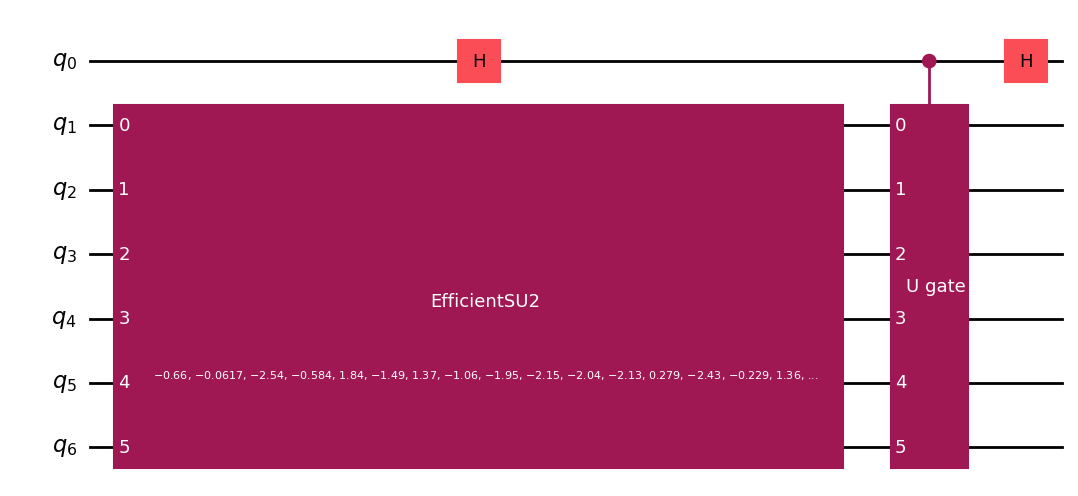

In [37]:
# Visualize the circuit
circuits[0].draw('mpl')

C:\Users\qilin\AppData\Local\Temp\ipykernel_29140\1661305099.py:2: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  U = circuits[0].data[2][0]
C:\Users\qilin\AppData\Local\Temp\ipykernel_29140\1661305099.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  single_gate_circuit.append(U, circuits[0].data[2][1])


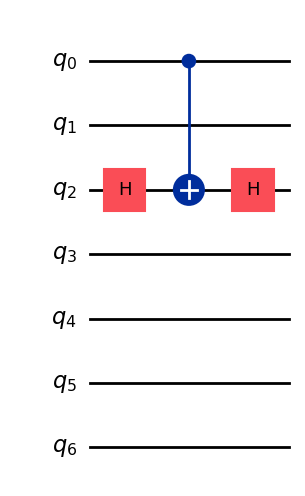

In [38]:
# Visualize the U gate
U = circuits[0].data[2][0] 
single_gate_circuit = QuantumCircuit(circuits[0].num_qubits) 
single_gate_circuit.append(U, circuits[0].data[2][1]) 
single_gate_circuit.decompose().draw('mpl')

In [40]:
# a = single_gate_circuit.data[0][0] 
# ansatz = QuantumCircuit(single_gate_circuit.num_qubits) 
# ansatz.append(a, single_gate_circuit.data[0][1]) 
# ansatz.decompose().draw('mpl')


In [42]:
from qiskit.quantum_info import Statevector

# Get the Statevector
state = Statevector.from_instruction(circuits[0])
#print("Statevector:", state)

# Probability of First Qubit Being |1⟩
# Statevector is indexed as |q1q0>, so we extract terms where q0=1
probability_first_qubit_1 = sum(
    abs(amplitude) ** 2
    for i, amplitude in enumerate(state)
    if (i & 0b01) == 0b01  # Check if the least significant bit (first qubit) is 1
)

print(f"Probability of first qubit being |1⟩: {probability_first_qubit_1}")


Probability of first qubit being |1⟩: 0.989672846559761


### 2 From very beginning

In [29]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2, TwoLocal, NLocal, RealAmplitudes, GroverOperator
from qiskit_nature.second_q.mappers import JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

def construct_ansatz(n, l, Str):
    if Str == 'EfficientSU2':
        qc = EfficientSU2(n, reps=l, entanglement='full', skip_unentangled_qubits=False, parameter_prefix='a')
    elif Str == 'Twolocal':
        qc = TwoLocal(n, ['ry','ry'], 'cx', 'full', reps=l, insert_barriers=False, parameter_prefix='a')
    elif Str == 'NLocal':
        qc = NLocal(n, ['ry','ry'], 'cx', 'full', reps=l, insert_barriers=False, parameter_prefix='a')    
    elif Str == 'RealAmplitudes':
        qc = RealAmplitudes(n, entanglement='full', reps=l, parameter_prefix='a')
    elif Str == "UCCSD":
        num_particles = (1, 1)
        num_spatial_orbitals = 5 
        mapper = BravyiKitaevMapper()
        init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
        qc = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state)
    else:
        raise Exception("Enter correct input")
    
    return qc, qc.parameters


def construct_A(l, opt_params, pauli_string):
    # Prepare the ansatz
    nqubits = len(pauli_string)
    ansatz, _ = construct_ansatz(nqubits, l=l, Str="EfficientSU2")
    opt_ansatz = ansatz.assign_parameters(opt_params)
    
    # Compose the Hadamard test
    A = QuantumCircuit(nqubits + 1)

    A = A.compose(opt_ansatz, range(1, nqubits + 1))
    
    # Create U gate based on pauli_string
    U = QuantumCircuit(nqubits)
    for i, pauli in enumerate(reversed(str(pauli_string))):  
        if pauli == 'X':
            U.x(i)
        elif pauli == 'Y':
            U.y(i)
        elif pauli == 'Z':
            U.z(i)
    U_gate = U.to_gate(label="U gate")

    # Create Hadamard test circuit
    HT = QuantumCircuit(nqubits + 1)
    HT.h(0)
    HT = HT.compose(U_gate.control(1), list(range(0, nqubits + 1)))
    HT.h(0)

    # Compose final A circuit
    A = A.compose(HT, range(0, nqubits + 1))

    return A

In [30]:
import dill
with open('../../../sorted_pauli_list.pkl', 'rb') as f:
    sorted_pauli_list = dill.load(f)
with open('../../../vqe_result.pkl', 'rb') as f:
    vqe_res = dill.load(f)

In [31]:
# Extract opt_params
opt_params = vqe_res['x']

# Set l
l = 12

In [32]:
pauli_string = sorted_pauli_list[3][0]
A = construct_A(l, opt_params, pauli_string)

In [33]:
for i, pauli in enumerate(reversed(str(pauli_string))): 
    print(i)
    print(pauli == 'Z')
    

False
0
True
1
False
2
False
3
False
4
False
5


C:\Users\qilin\AppData\Local\Temp\ipykernel_29140\1284399588.py:2: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  U = A.data[2][0]
C:\Users\qilin\AppData\Local\Temp\ipykernel_29140\1284399588.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  single_gate_circuit.append(U, A.data[2][1])


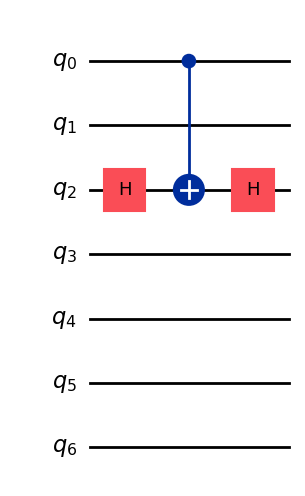

In [34]:
# Visualize the U gate
U = A.data[2][0] 
single_gate_circuit = QuantumCircuit(A.num_qubits) 
single_gate_circuit.append(U, A.data[2][1]) 
single_gate_circuit.decompose().draw('mpl')